In [1]:
import numpy as np
import matplotlib.pyplot as plt
from imripy import constants as c, kepler, merger_system as ms, inspiral, plot_utils as pu
from imripy.inspiral import forces
from imripy.kepler import KeplerOrbit

## Define 2 body system

In [2]:
m1 = 1e3 * c.solar_mass_to_pc
m2 = 1. * c.solar_mass_to_pc

hs = ms.HostSystem(m1)

In [3]:
# The dissipative effects of the GW emission
gw = forces.GWLoss()

## Define example force
Example force such that $F = F_0 r^{\alpha} v^{\beta} $

In [4]:
alpha = -1.5
beta = -1.
k_1 = 3./2. + alpha - beta/2.
F_0 = 5e-28

F_ex = forces.ParameterizedForce(alpha, beta, F_0)

### Look at streamline plot of force

/media/data/Documents/PhD/imripy/src/imripy/inspiral/forces.py:264: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  return -(1.-e**2)**(3./2.)/2./np.pi *np.sqrt(ko.m_tot * a*(1.-e**2))* quad(integrand, 0., 2.*np.pi, limit = 100)[0]


(-5.000000000001976, 0.0)

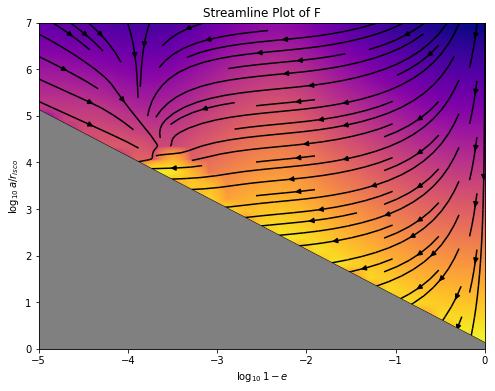

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.-np.geomspace(1e-5, 1., 25)

# Define the EvolutionOptions object with the force
opt_F = inspiral.Classic.EvolutionOptions( dissipativeForces=[F_ex])

# Kepler Orbit object, but a and e will be overwritten by a_grid, e_grid
# Is useful in case the force is not spherically symmetric, e.g. inclination_angle can be changed here
ko = KeplerOrbit(hs, m2, 0.)

pu.streamline(ax, hs, opt_F, ko, a_grid, e_grid)

ax.set_title("Streamline Plot of F")
ax.set_xlabel(r"$\log_{10} 1-e$"); ax.set_ylabel(r"$\log_{10} a/r_{isco}$")
ax.set_xlim(right=0.)

### Streamline plot with GW emission

(-5.000000000001976, 0.0)

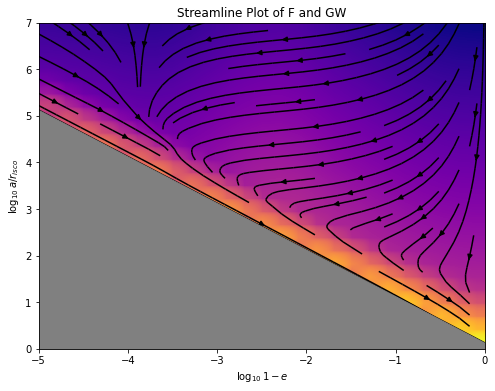

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))
a_grid = np.geomspace(hs.r_isco, 1e7*hs.r_isco, 25)
e_grid = 1.-np.geomspace(1e-5, 1., 25)

# Define the EvolutionOptions object with the force and GW loss
opt_F_gw = inspiral.Classic.EvolutionOptions( dissipativeForces=[F_ex, gw])

ko = KeplerOrbit(hs, m2, 0.)

pu.streamline(ax, hs, opt_F_gw, ko, a_grid, e_grid)

ax.set_title("Streamline Plot of F and GW")
ax.set_xlabel(r"$\log_{10} 1-e$"); ax.set_ylabel(r"$\log_{10} a/r_{isco}$")
ax.set_xlim(right=0.)

## Example Inspiral

In [7]:
a0 = 1e4* hs.r_isco
e0 = 0.1
ko = KeplerOrbit(hs, m2, a0, e=e0)

In [8]:
# We define the relevant forces in the evolution options object
opt_F = inspiral.Classic.EvolutionOptions( dissipativeForces=[F_ex],  accuracy=1e-8)

ev_F = inspiral.Classic.Evolve(hs, ko, opt=opt_F)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {ParameterizedForce, }, accuracy = 1.0e-08
A termination event occurred.
 -> Ended at 4.462e+00r_isco. Evolution took 0.0931s real time


In [9]:
opt_F_gw = inspiral.Classic.EvolutionOptions( dissipativeForces=[gw, F_ex], accuracy=1e-8)

ev_F_gw = inspiral.Classic.Evolve(hs, ko, opt=opt_F_gw)

Evolving from  10000.0  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {GWLoss, ParameterizedForce, }, accuracy = 1.0e-08
A termination event occurred.
 -> Ended at 2.656e+00r_isco. Evolution took 0.1435s real time


The solution follows the streamlines

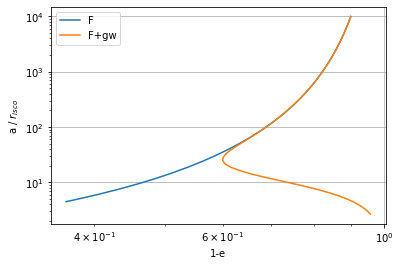

In [10]:
fig, ax = plt.subplots()

pu.plotEvolution(hs, ev_F, ax_1mea=ax, label="F")
pu.plotEvolution(hs, ev_F_gw, ax_1mea=ax, label="F+gw")
ax.set_xlabel("1-e"); ax.set_ylabel("a / $r_{isco}$");
ax.grid(); ax.legend();

## Estimating timescales

Internally, the time to inspiral is estimated with just GW emission. 
Depending on the relevant forces, this can be too large or small, and cause numerical issues

In [11]:
alpha = -1.5
beta = -1.
F_0 = 1e-20 # Strong force

F_2 = forces.ParameterizedForce(alpha, beta, F_0)
opt_F_2 = inspiral.Classic.EvolutionOptions( dissipativeForces=[F_2])

ko = KeplerOrbit(hs, m2, 1e6*hs.r_isco, e=0.1) # 

ev_F_2 = inspiral.Classic.Evolve(hs, ko, opt=opt_F_2)

Evolving from  1000000.0000000001  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {ParameterizedForce, }, accuracy = 1.0e-10


ValueError: `ts` must be strictly increasing or decreasing.

The timescale can be estimated with $t = \frac{E}{|\frac{dE}{dt}|}$, the time to reduce the energy by an order of itself

In [12]:
t_F_2 = np.abs(inspiral.Classic.E_orbit(hs, ko, opt=opt_F_2) / F_2.dE_dt(hs, ko, opt=opt_F_2))

ev_F_2 = inspiral.Classic.Evolve(hs, ko, t_fin= 10.* t_F_2, opt=opt_F_2)

Evolving from  1000000.0000000001  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {ParameterizedForce, }, accuracy = 1.0e-10
A termination event occurred.
 -> Ended at 3.380e+01r_isco. Evolution took 0.3076s real time


Or the accuracy can be reduced

In [13]:
opt_F_2 = inspiral.Classic.EvolutionOptions( dissipativeForces=[F_2], accuracy=1e-6)

ev_F_2 = inspiral.Classic.Evolve(hs, ko, opt=opt_F_2)

Evolving from  1000000.0000000001  to  1.0 r_isco  with initial eccentricity 0.1  with  Options: dissipative forces employed {ParameterizedForce, }, accuracy = 1.0e-06
A termination event occurred.
 -> Ended at 2.952e+01r_isco. Evolution took 0.1113s real time
